# ML-3B. Классификация

## 3B.2. Метрики качества классификации


In [1]:
from sklearn.model_selection import train_test_split # функция, чтобы разбить данные на трейн и тест
from sklearn.linear_model import LogisticRegression # наша модель для классификации

from sklearn.datasets import load_breast_cancer # подгружаем датасет


breast_cancer = load_breast_cancer()

In [2]:
Y = breast_cancer.target ## Наша целевая переменная, 0 — если рака нет, 1 — если есть 
X = breast_cancer.data # X - признаки, по которым мы будем предсказывать рак 

In [3]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3)
model = LogisticRegression()
model.fit(X_train, Y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Y_predicted = model.predict(X_val)
print(accuracy_score(Y_val,Y_predicted))
print(precision_score(Y_val,Y_predicted))
print(recall_score(Y_val,Y_predicted))
print(f1_score(Y_val,Y_predicted))

0.9473684210526315
0.9339622641509434
0.9801980198019802
0.9565217391304348


# 3B.6. Логистическая регрессия. Практика

In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

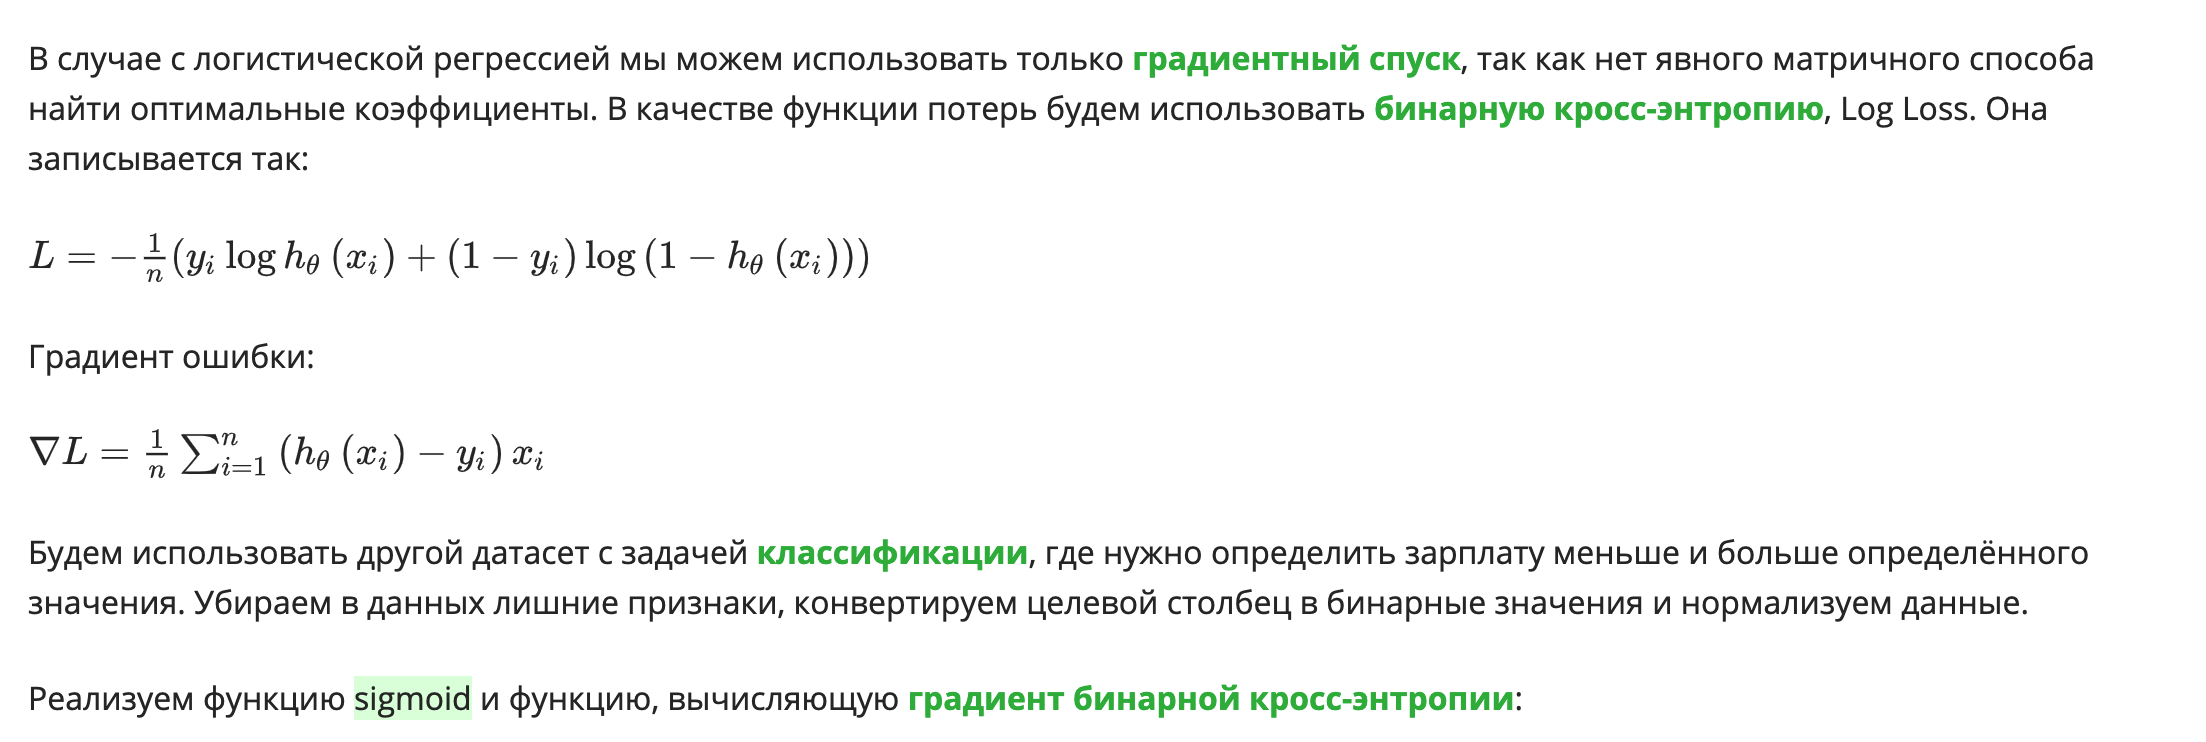

In [6]:
def sigmoid(X, theta):
    return 1. / (1. + np.exp(-X.dot(theta)))

def calc_binary_cross_entropy_grad(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(sigmoid(X, theta) - y)
    
    return grad

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad
def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta

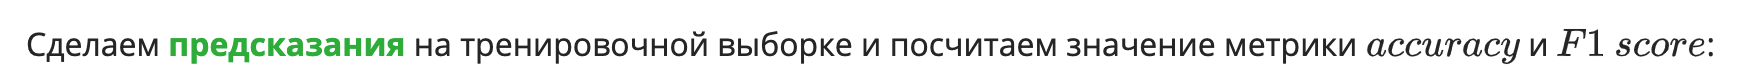

In [7]:
y_pred = sigmoid(X, theta) > 0.5
print_logisitc_metrics(y, y_pred)

NameError: name 'theta' is not defined

Мы уже знаем, что этой выборке нельзя доверять, поэтому разбиваем данные и оптимизируем:

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = optimize(X_train, y_train, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)
y_pred = sigmoid(X_valid, theta) > 0.5

print_logisitc_metrics(y_valid, y_pred)

NameError: name 'y' is not defined

Результат практически тот же. Отрисуем ROC-кривую, посчитаем её значения и значение площади под кривой AUC.

Для борьбы с переобучением добавим регуляризацию. Обернём линейную регрессию в класс:

In [10]:
class RegOptimizer():
    def __init__(self, alpha, n_iters):
        self.theta = None
        self._alpha = alpha
        self._n_iters = n_iters
    
    def gradient_step(self, theta, theta_grad):
        return theta - self._alpha * theta_grad
    
    def grad_func(self, X, y, theta):
        raise NotImplementedError()

    def optimize(self, X, y, start_theta, n_iters):
        theta = start_theta.copy()

        for _ in range(n_iters):
            theta_grad = self.grad_func(X, y, theta)
            theta = self.gradient_step(theta, theta_grad)

        return theta
    
    def fit(self, X, y):
        m = X.shape[1]
        start_theta = np.ones(m)
        self.theta = self.optimize(X, y, start_theta, self._n_iters)
        
    def predict(self, X):
        raise NotImplementedError()

Проделаем ту же операцию с логистичекой регрессией:

In [23]:
class LogReg(RegOptimizer):
    def sigmoid(self, X, theta):
        return 1. / (1. + np.exp(-X.dot(theta)))
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, theta) - y)

        return grad
    
    def predict_proba(self, X):
        return self.sigmoid(X, self.theta)
    
    def predict(self, X):
        if self.theta is None:
            raise Exception('You should train the model first')
        
        y_pred = self.predict_proba(X) > 0.5
        
        return y_pred

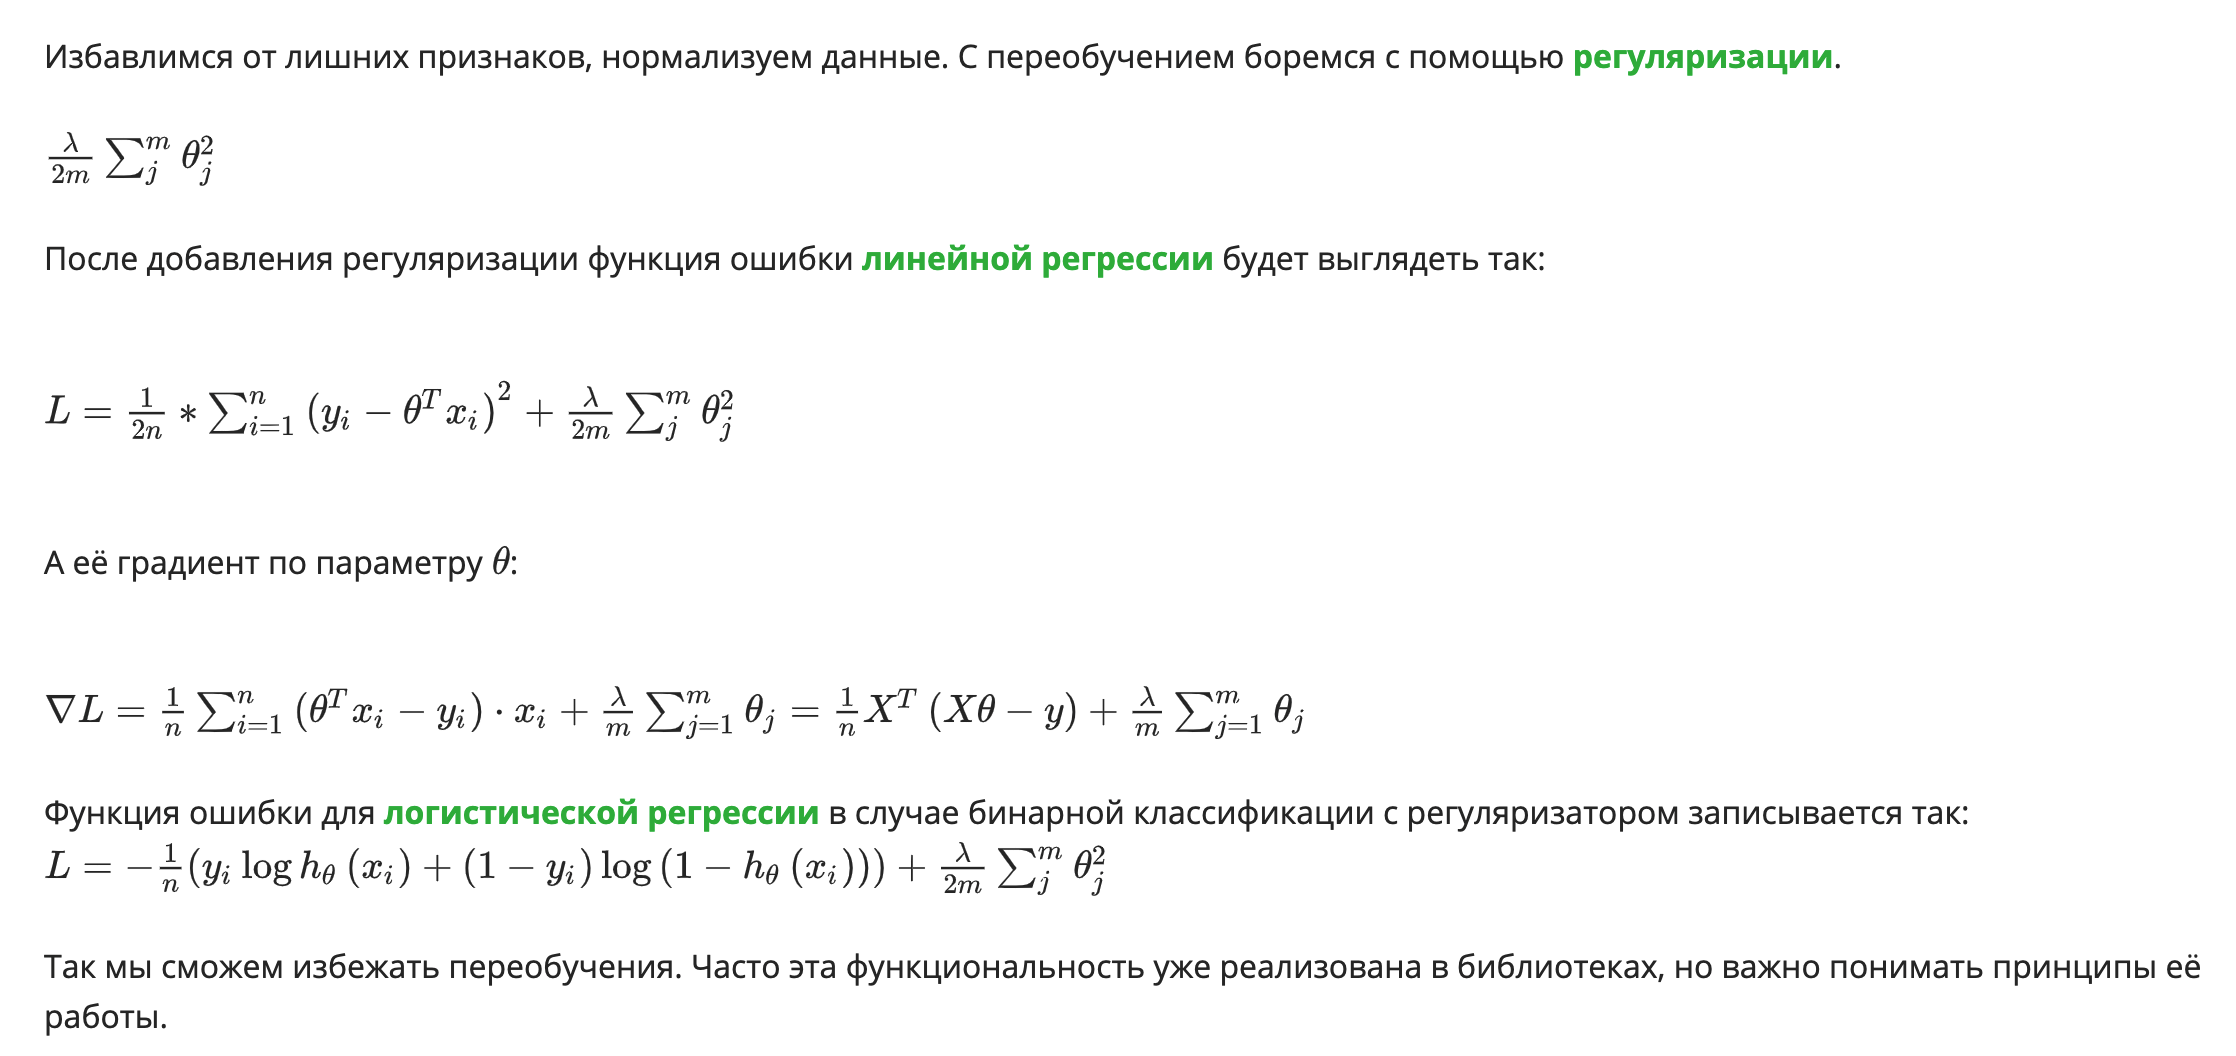

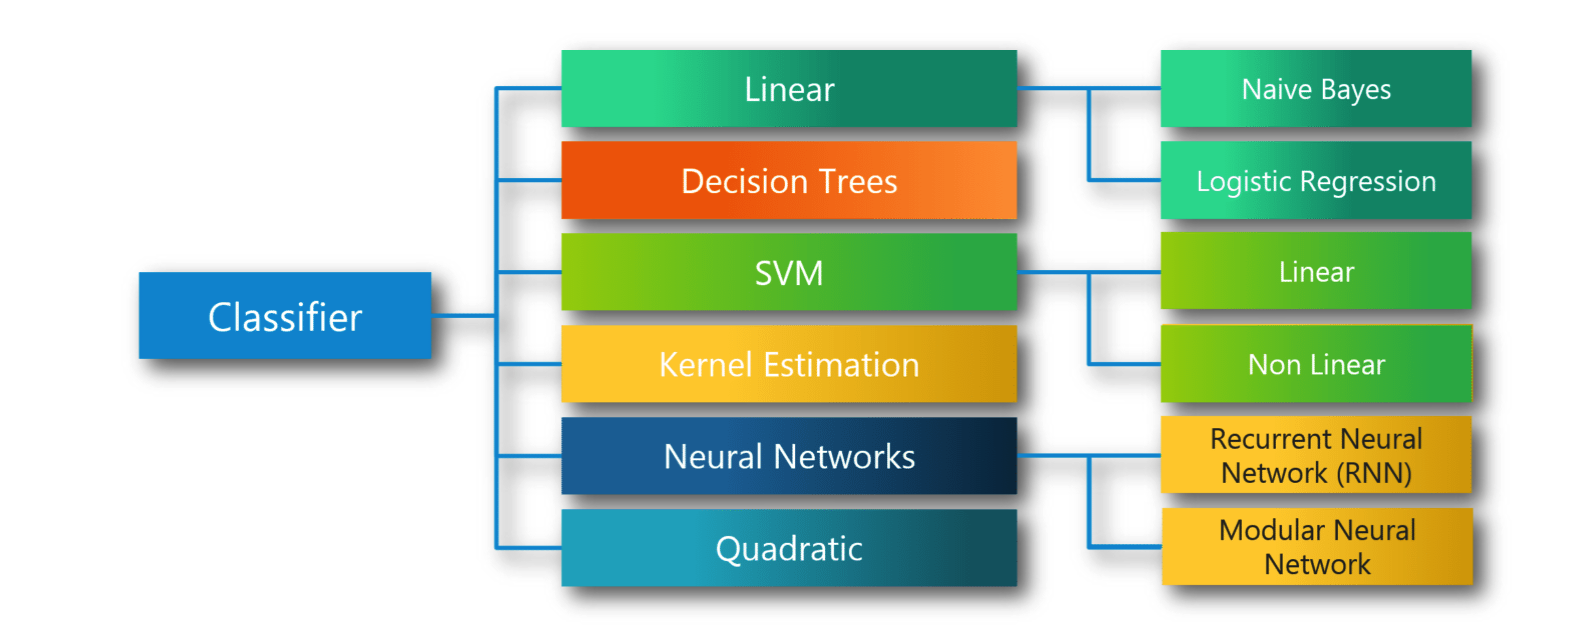

In [24]:
!ls -la ./additionally/ml-3b/adult.data

-rw-r--r--@ 1 obiriukov  staff  3974305 24 апр 15:57 ./additionally/ml-3b/adult.data


In [25]:
adult = pd.read_csv('./additionally/ml-3b/adult.data',
                    names=['age', 'workclass', 'fnlwgt', 'education',
                           'education-num', 'marital-status', 'occupation',
                           'relationship', 'race', 'sex', 'capital-gain',
                           'capital-loss', 'hours-per-week', 'native-country', 'salary'])

In [27]:
adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
